# Download and post-process MODIS ET 

MODIS product:

|Product|File name|Spatial resolution|Temporal resolution|Period|
|---|---|---|---|---|
|LAI|MCD15A3H.0.61_500m_aid0001.nc|500-m|4-day|2002-07-01 - present|
|Landcover|MCD12Q1.0.61_500m_aid0001.nc|500-m|yearly|2001-01-01 - present|
|ET|MOD16A2GF.0.61_500m_aid0001.nc|500-m|8-day|2000-01-01 - present|
|Snowcover|MOD10A2.0.61_500m_aid0001.nc|500-m|6-day?|2000-02-24 - present|

In [ ]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import geopandas as gpd
from shapely.geometry import mapping
import netCDF4 as nc
from datetime import date, datetime, timedelta
import calendar
from scipy.signal import savgol_filter
import cartopy
import shutil

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [ ]:
name = 'YellowStone'
fname_watershed_shp = f'../../data-processed/{name}/{name}_bounds.shp'
data_raw_dir = f'../../MODIS_raw/{name}/'
data_processed_dir = f'../../data-processed/{name}/'

fname_lai = data_raw_dir + '/MCD15A3H.061_500m_aid0001.nc'
fname_lulc = data_raw_dir + '/MCD12Q1.061_500m_aid0001.nc'
fname_et = data_raw_dir + '/MOD16A2GF.061_500m_aid0001.nc'
fname_snowcover = data_raw_dir + '/MOD10A2.061_500m_aid0001.nc'

# Import shapefile to provide the coordinates

In [ ]:
watershed_shape = gpd.read_file(fname_watershed_shp)
bounds = watershed_shape.bounds

In [ ]:
def get_bounds(fname_watershed_shp):
    """get the min,max bounds for lat,lon for a given watershed."""
    watershed_shape = gpd.read_file(fname_watershed_shp)

    bounds = watershed_shape.bounds
    # bounds

    lonl = watershed_shape.bounds['minx'].values[0]
    lonr = watershed_shape.bounds['maxx'].values[0]
    latb = watershed_shape.bounds['miny'].values[0]
    latt = watershed_shape.bounds['maxy'].values[0]    
    
    return lonl,lonr,latb,latt

lonl,lonr,latb,latt = get_bounds(fname_watershed_shp)
lonl,lonr,latb,latt

# Subset data

In [ ]:
dset = xr.open_dataset(fname_et)
data = dset.ET_500m
mask_data = data.where((data < 1000) & (data >= 0))
mask_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mask_data.rio.write_crs("epsg:4326", inplace=True)
ET_data = mask_data.rio.clip(watershed_shape.geometry.apply(mapping), watershed_shape.crs, drop = True)

In [ ]:
# ET_data.values /= 8

In [ ]:
# ET_data.time.values.shape

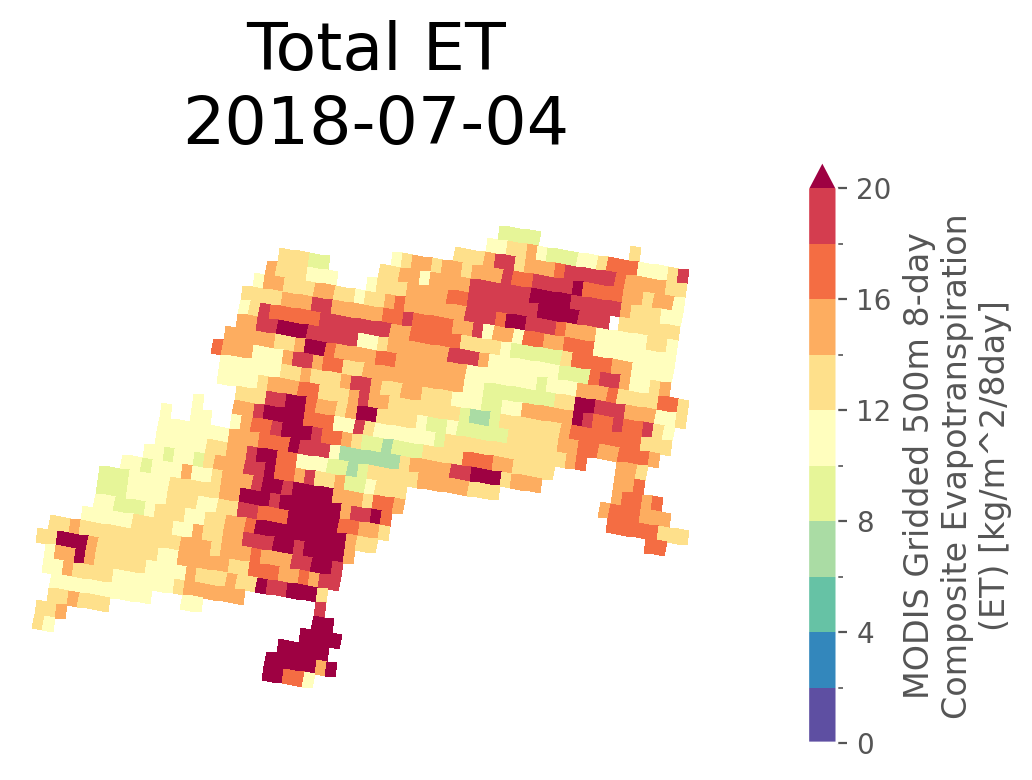

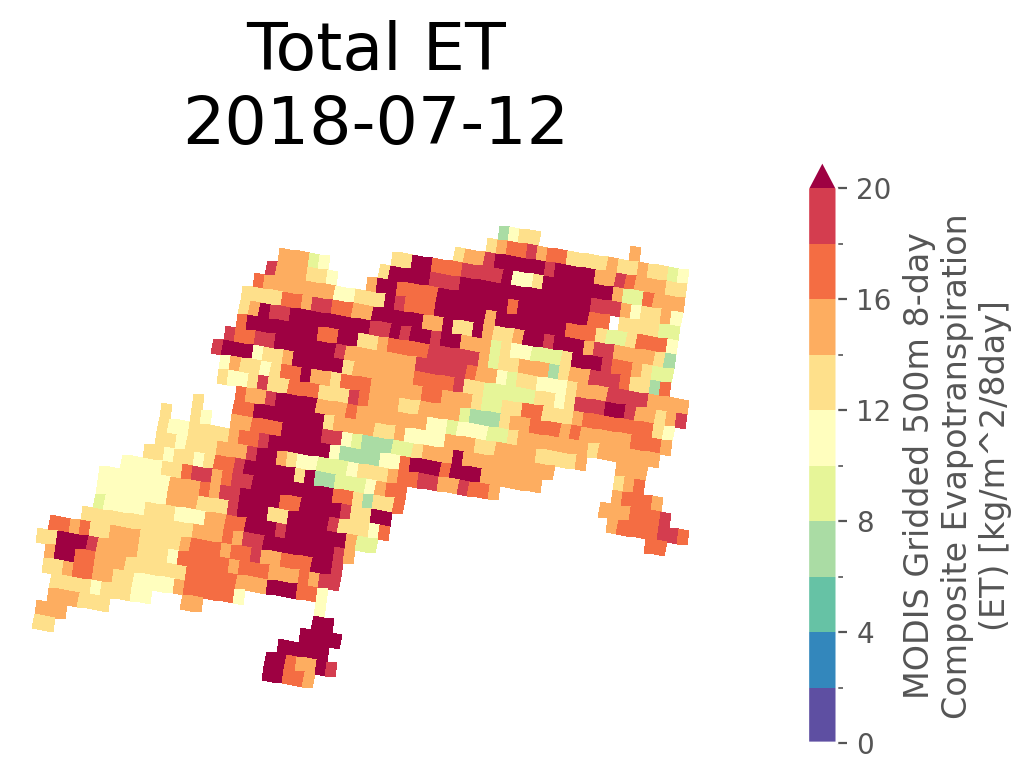

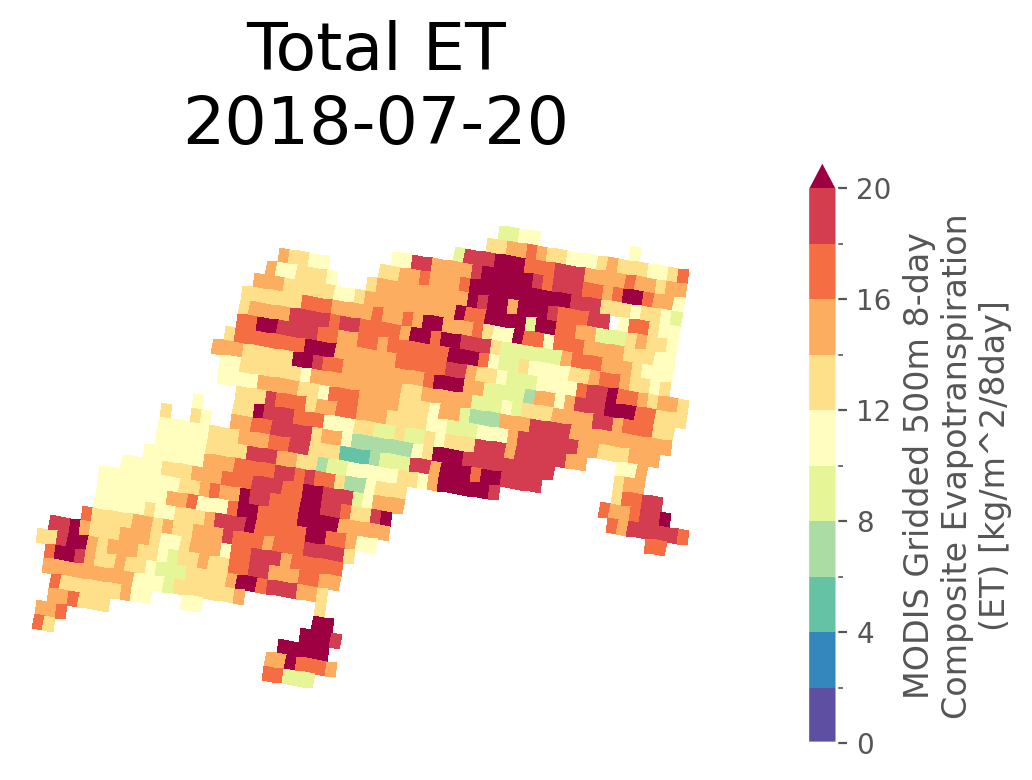

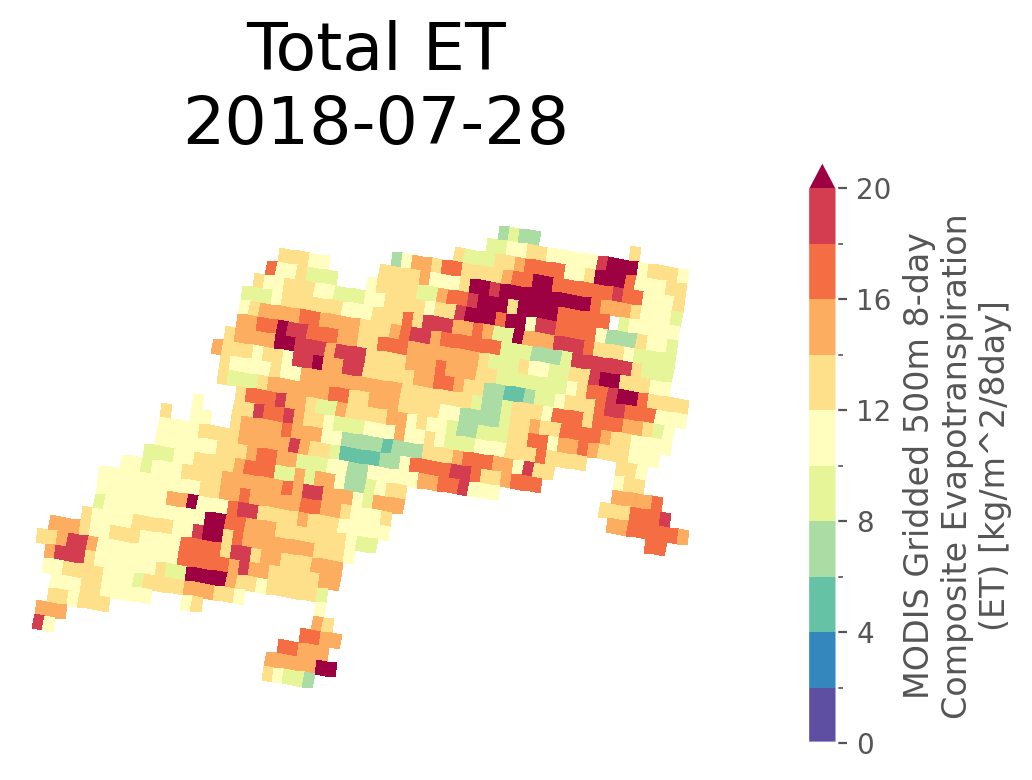

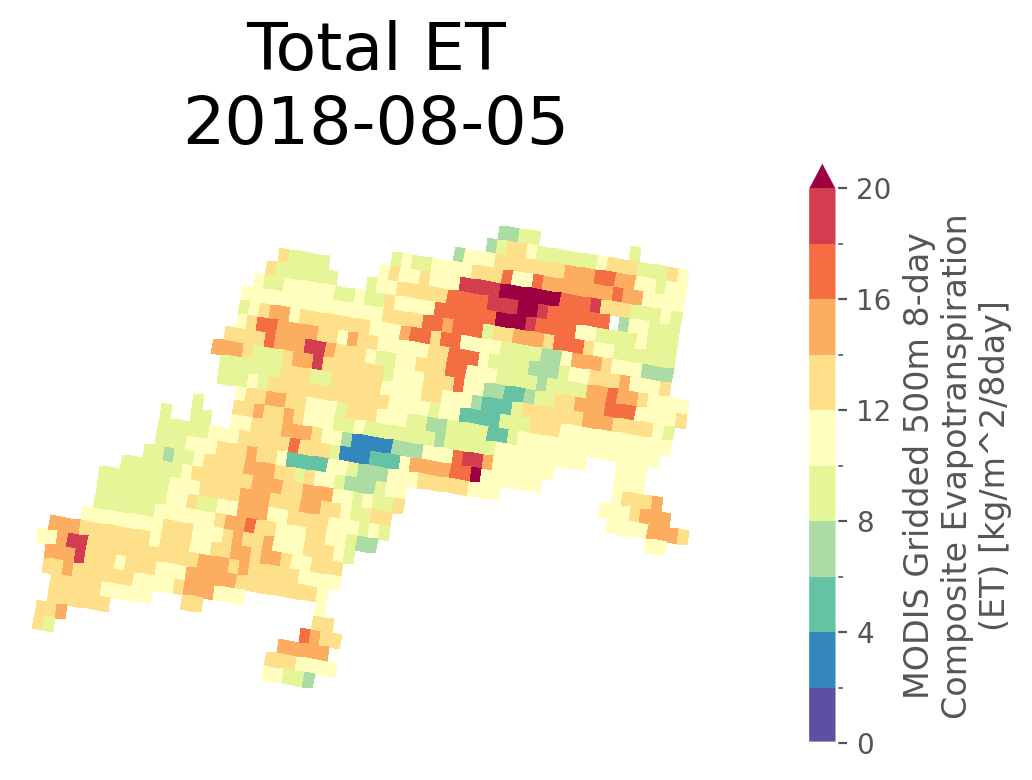

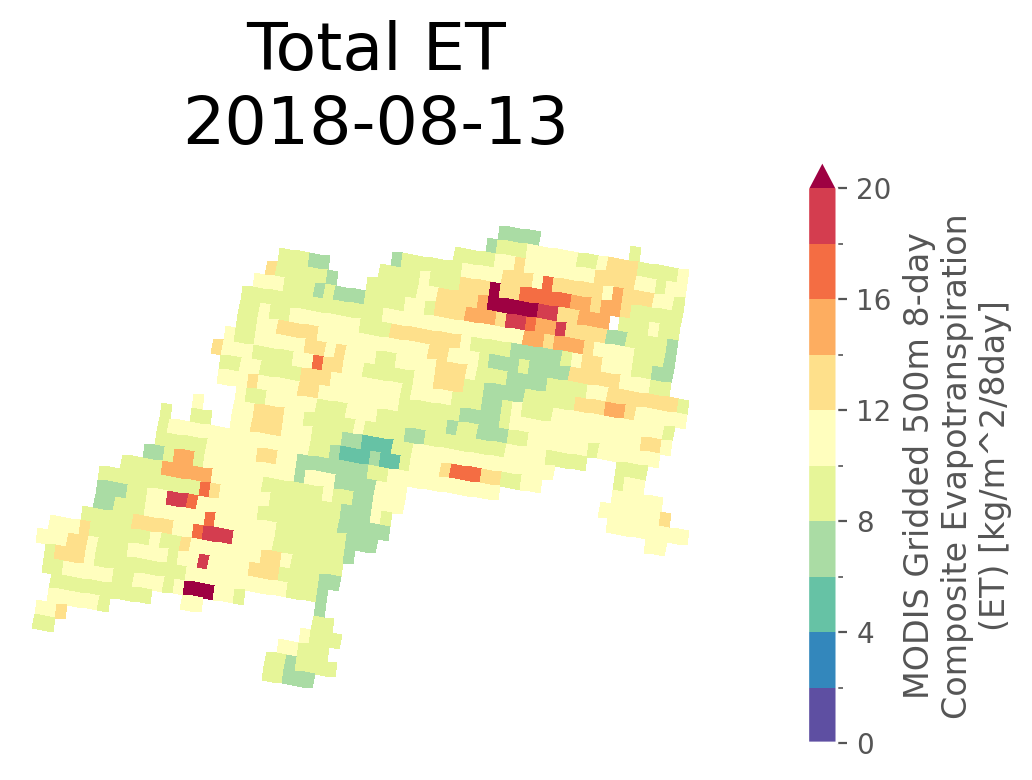

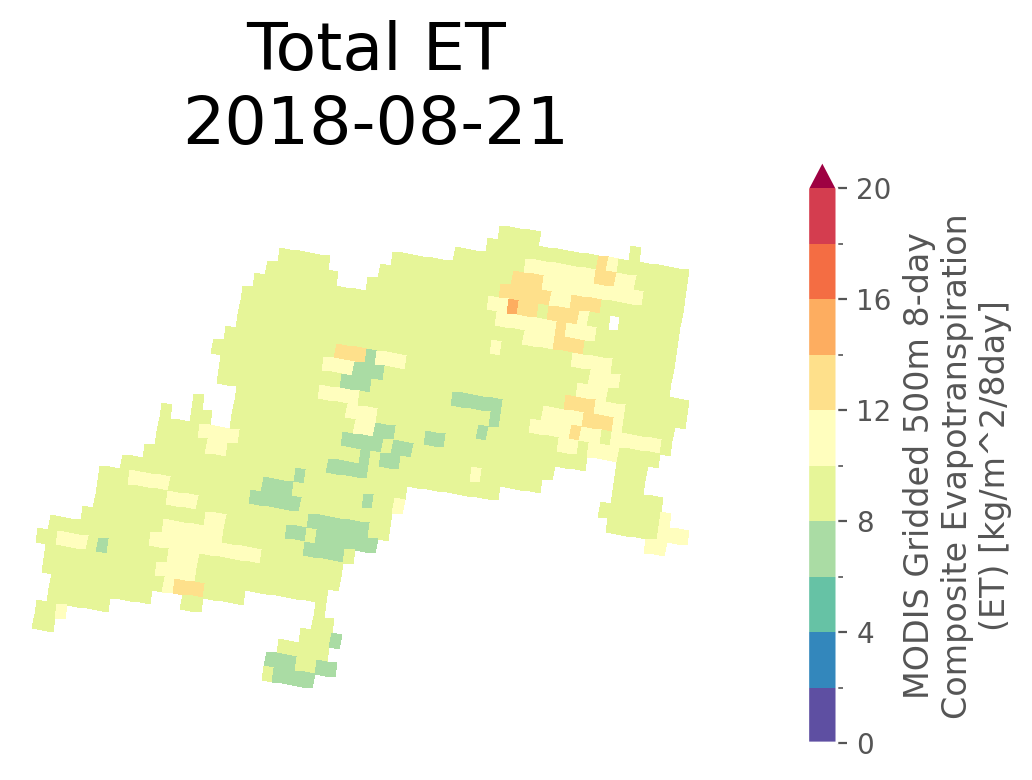

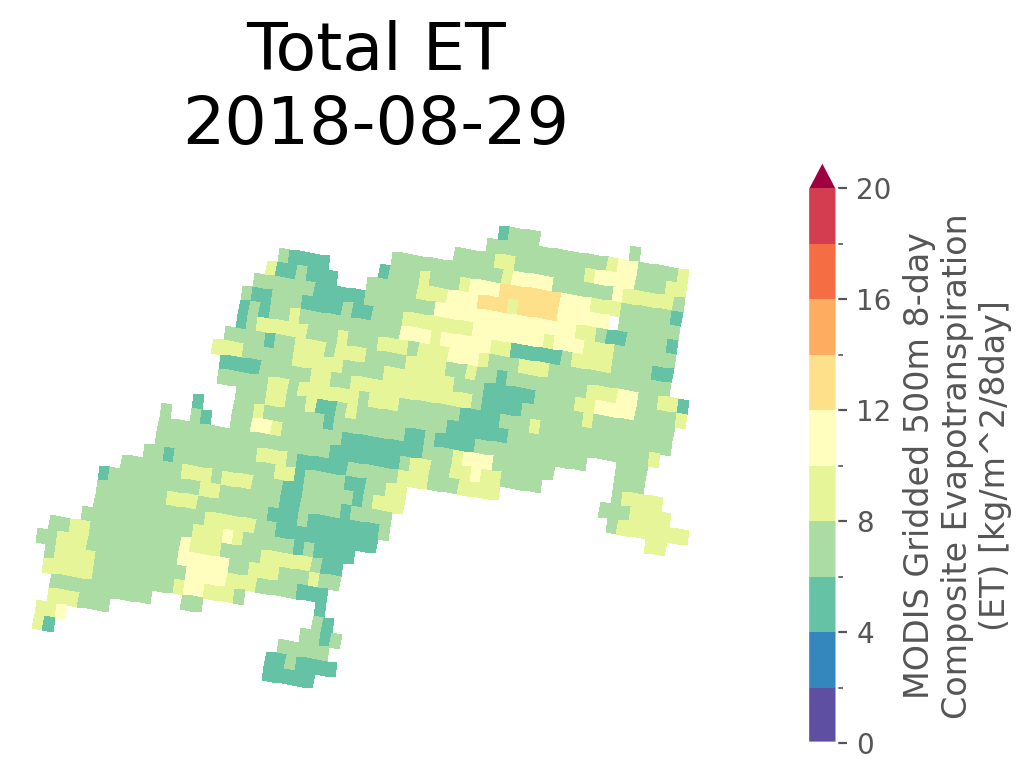

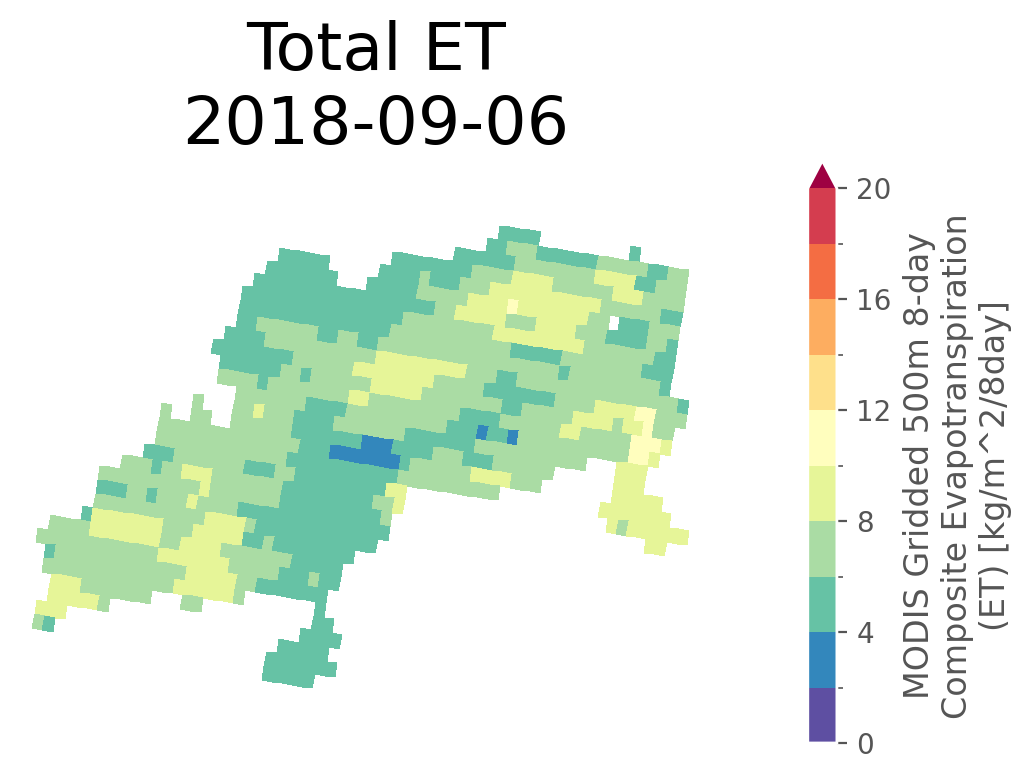

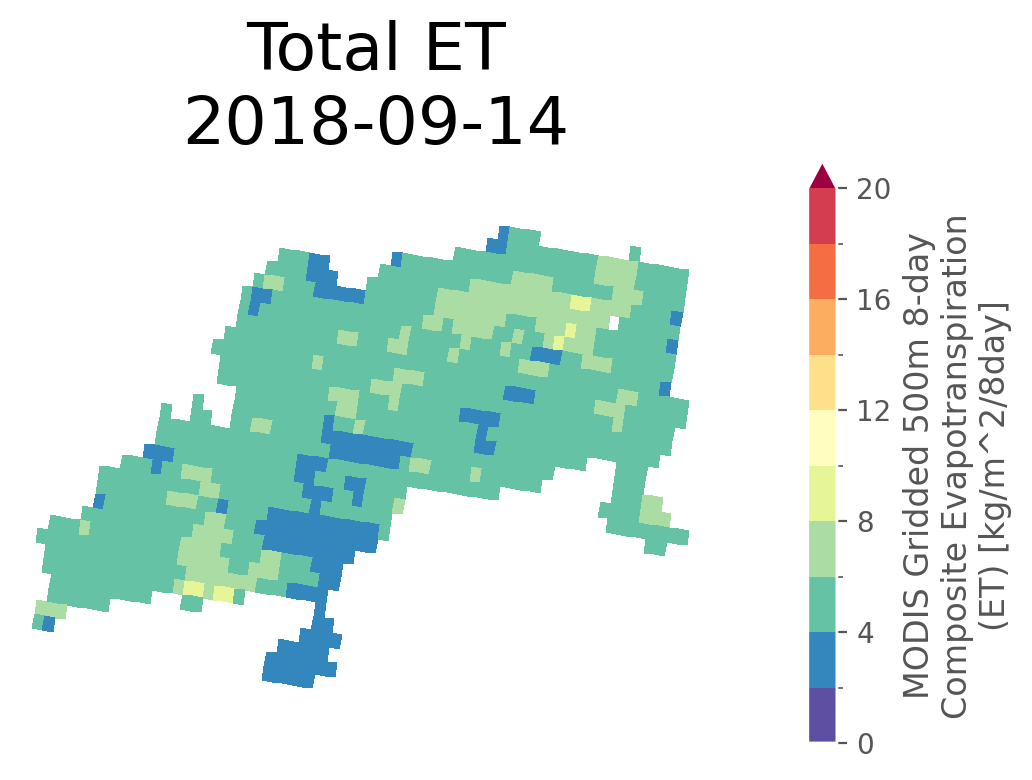

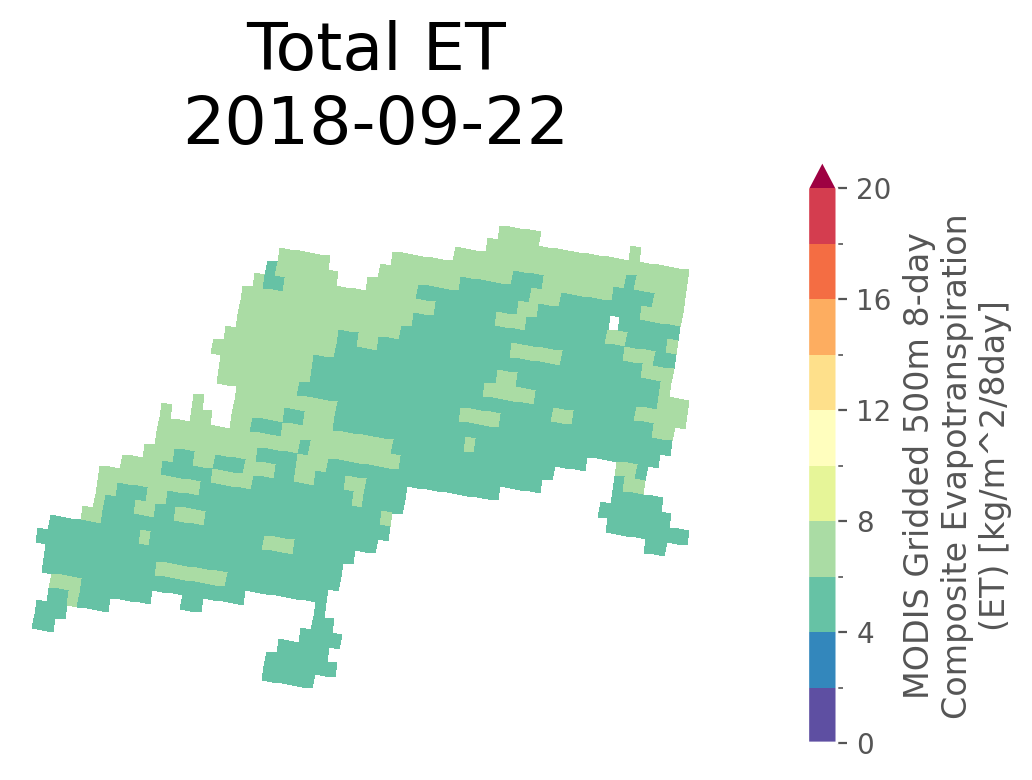

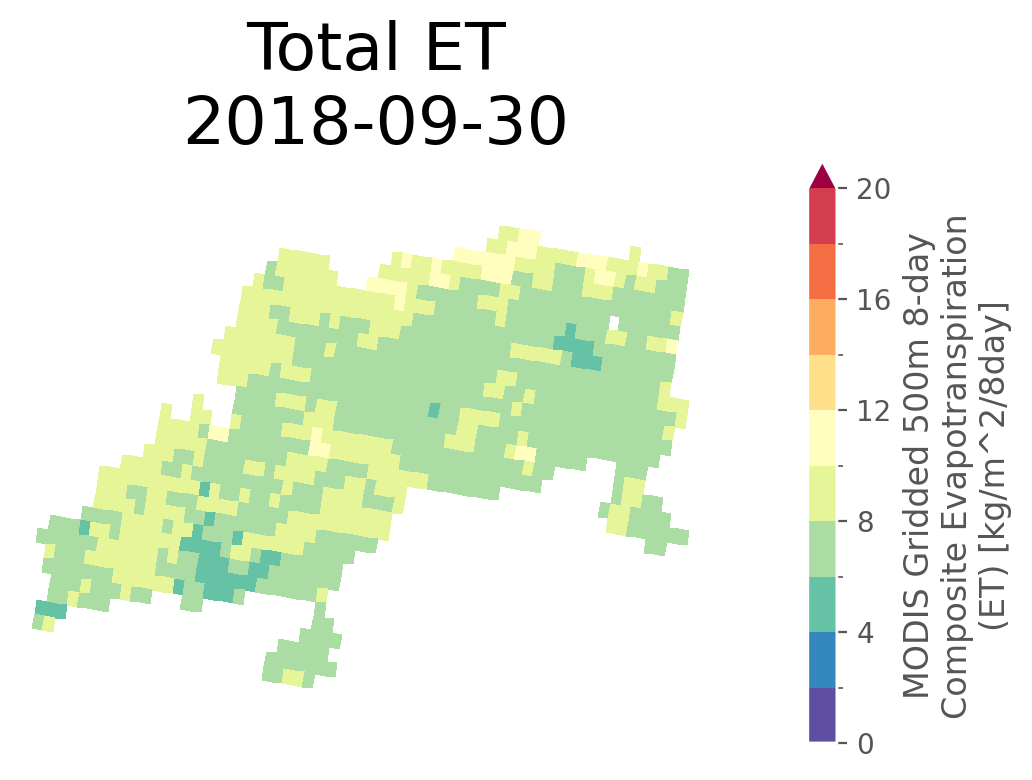

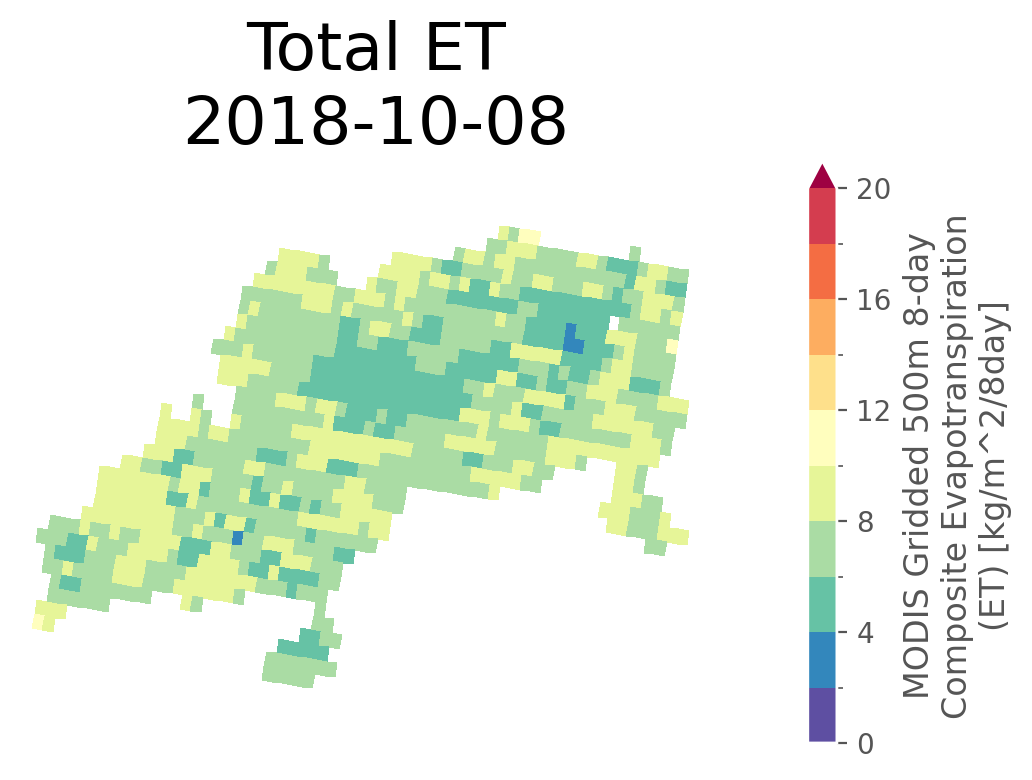

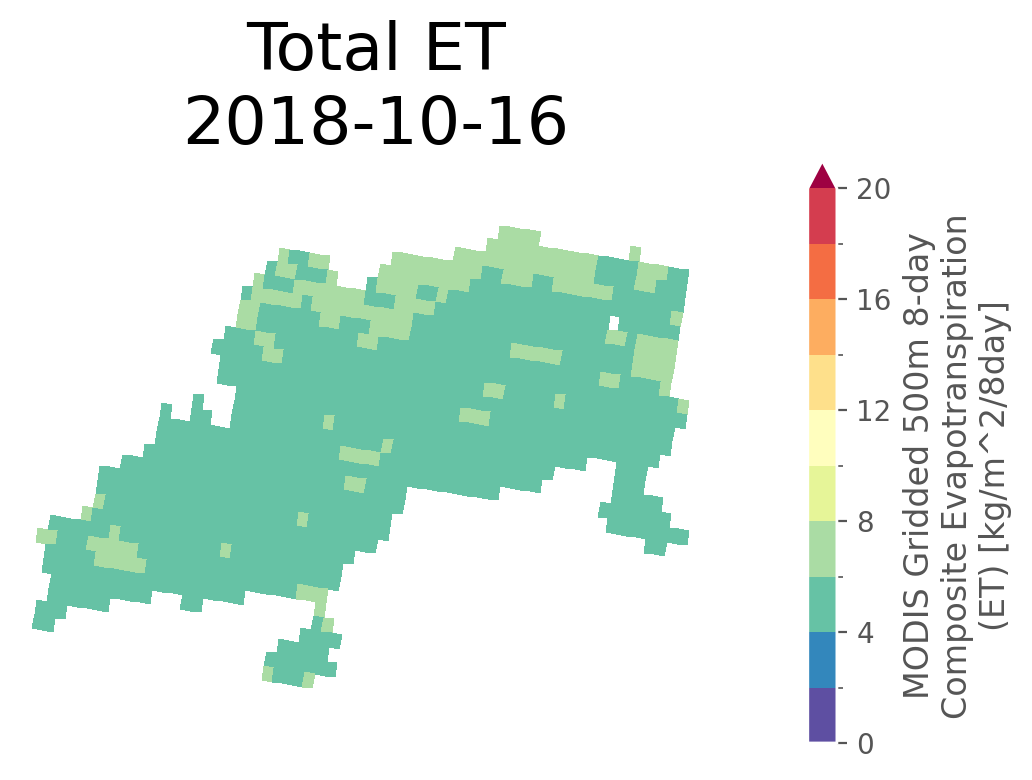

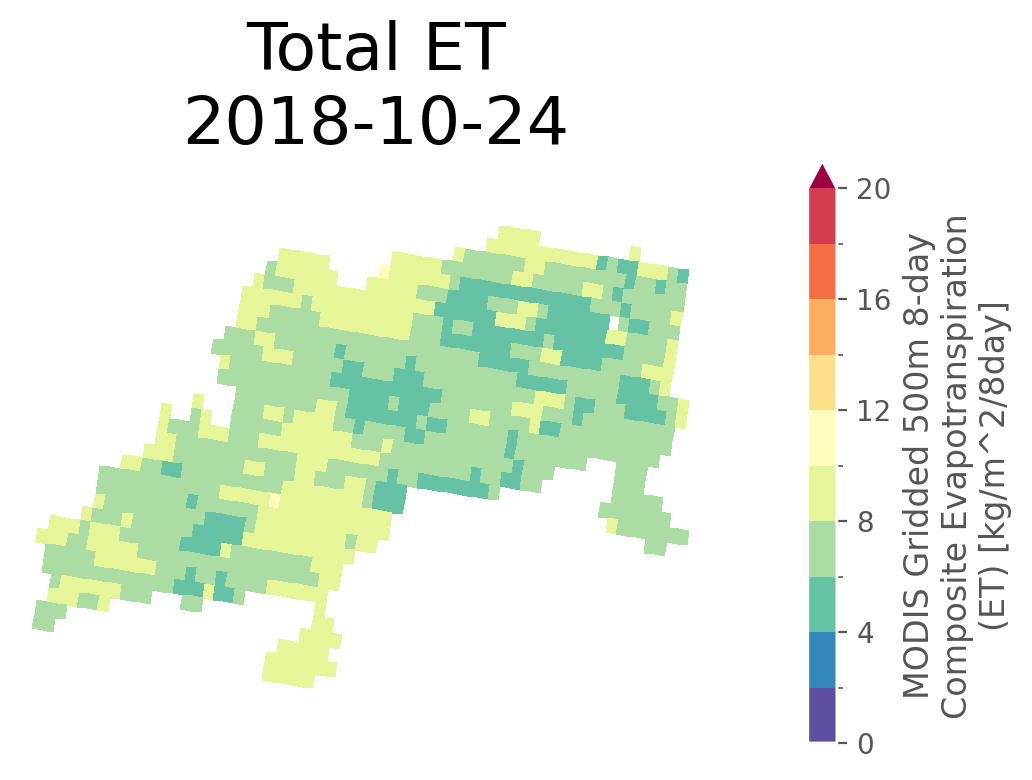

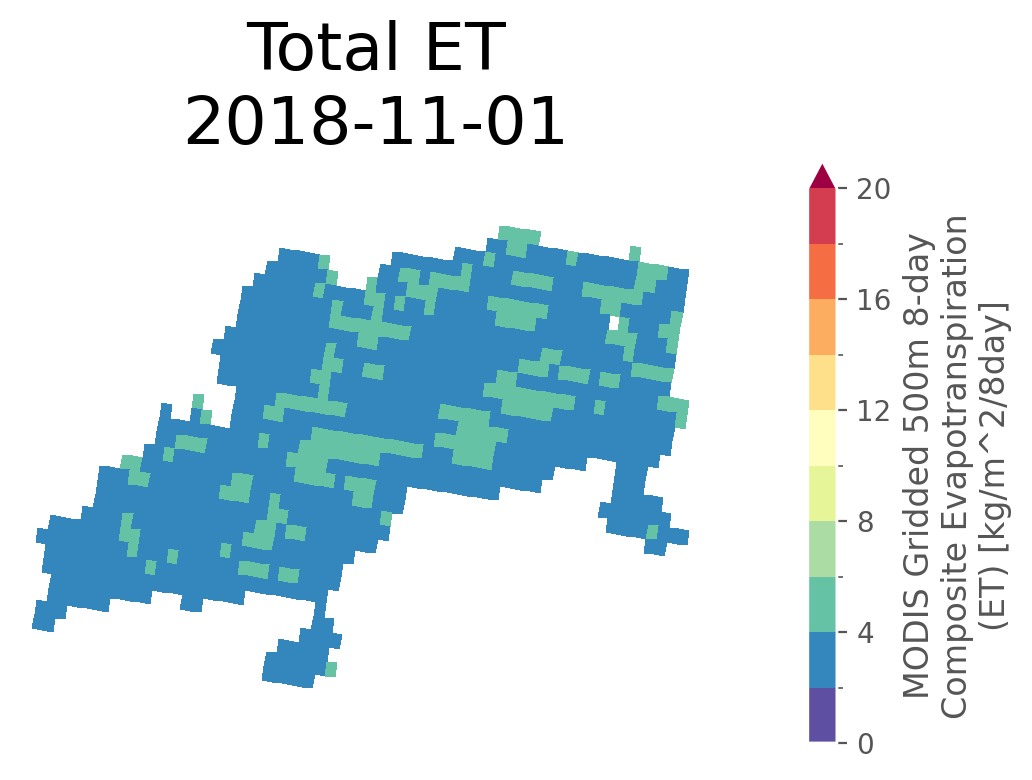

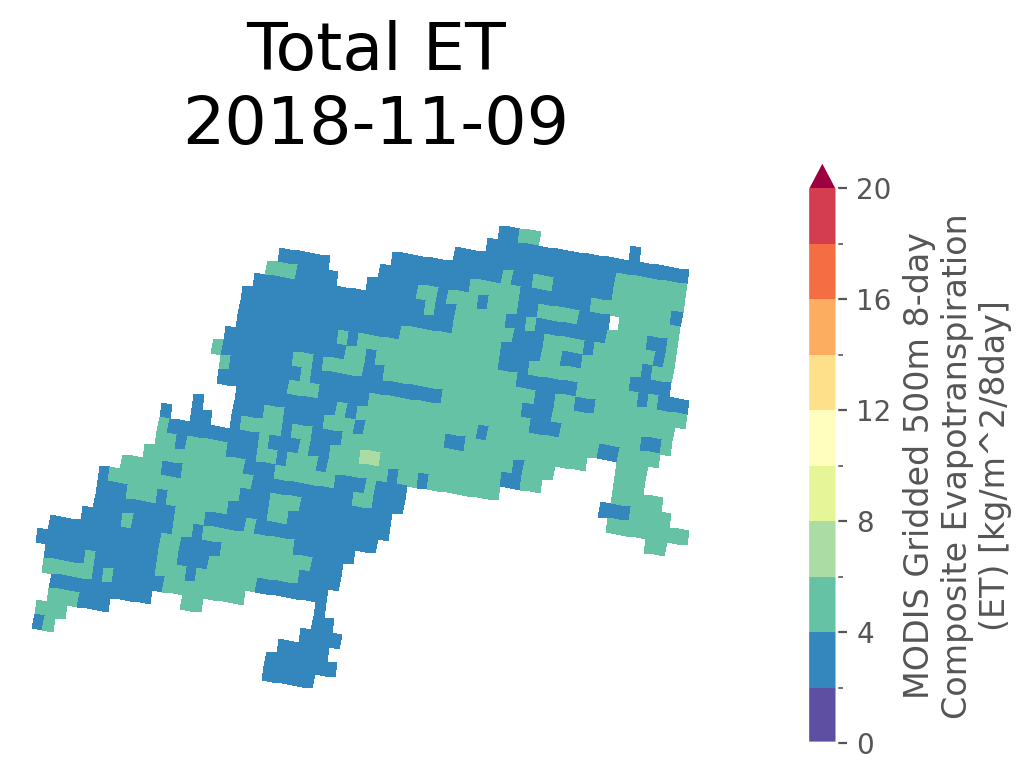

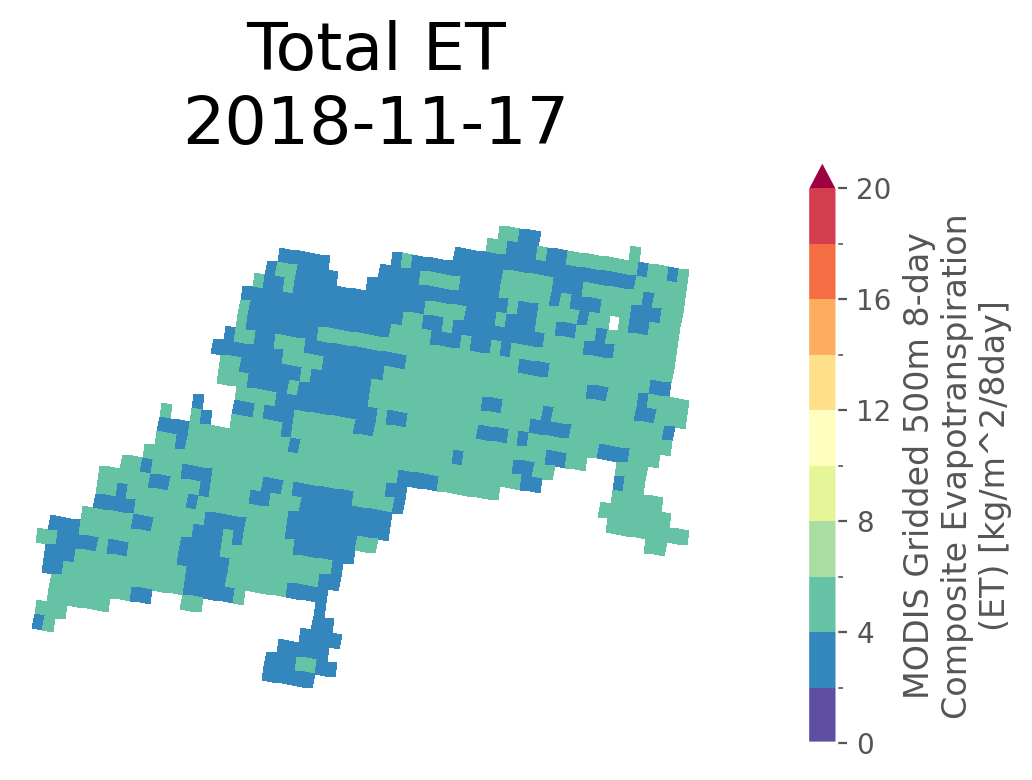

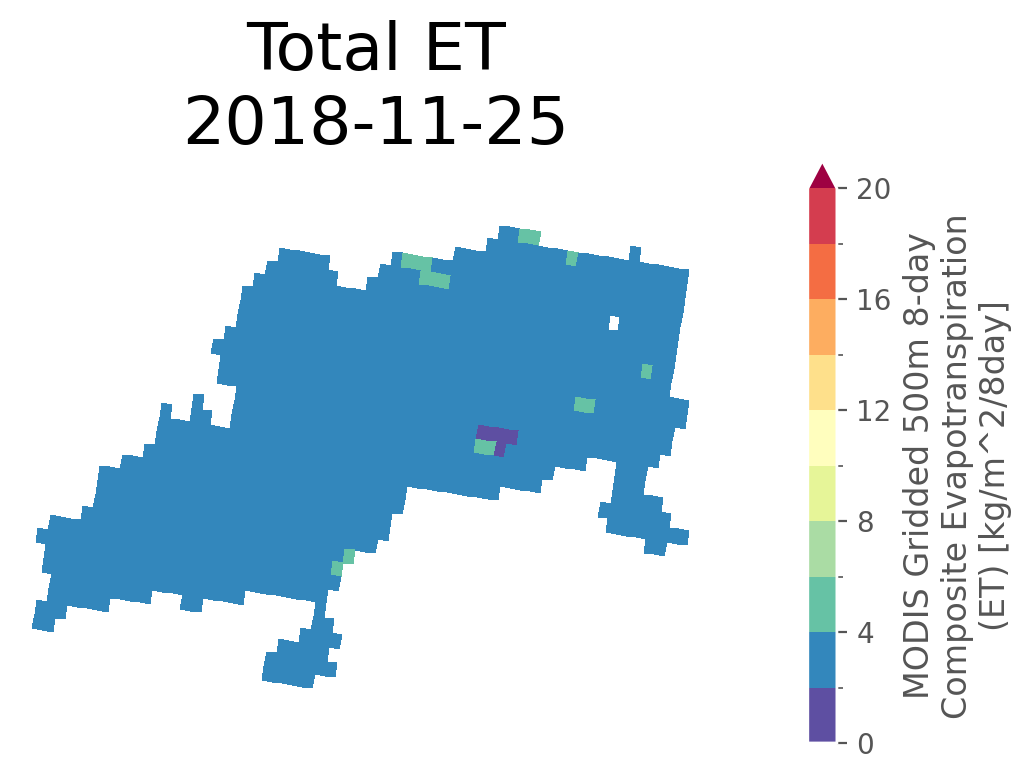

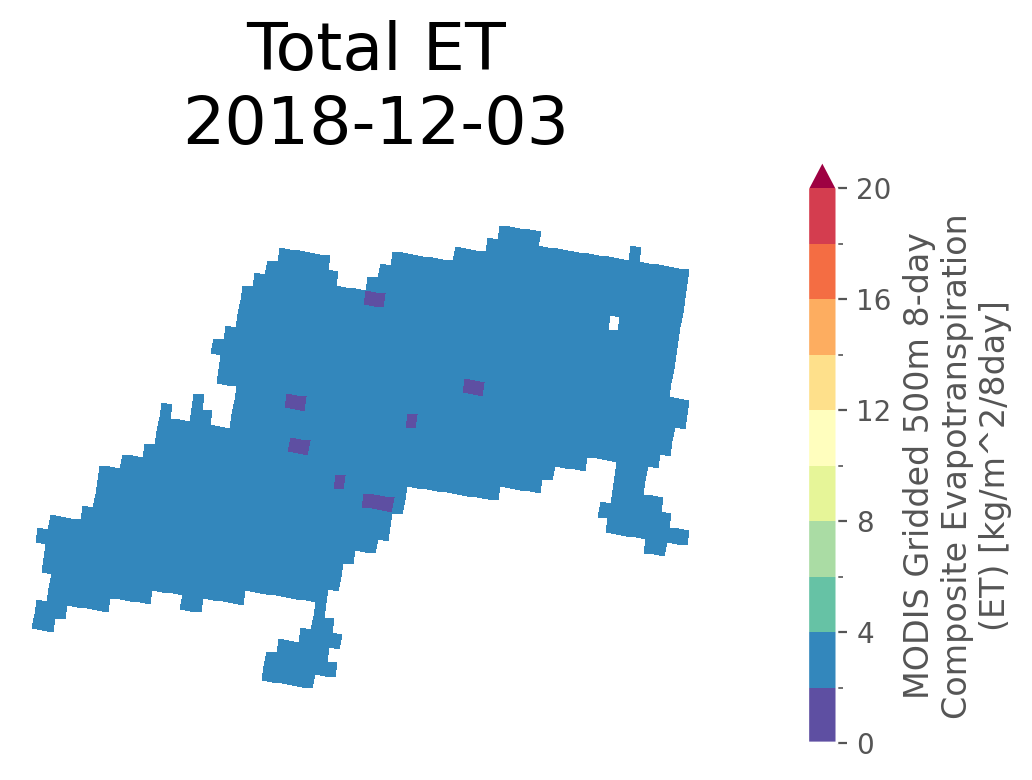

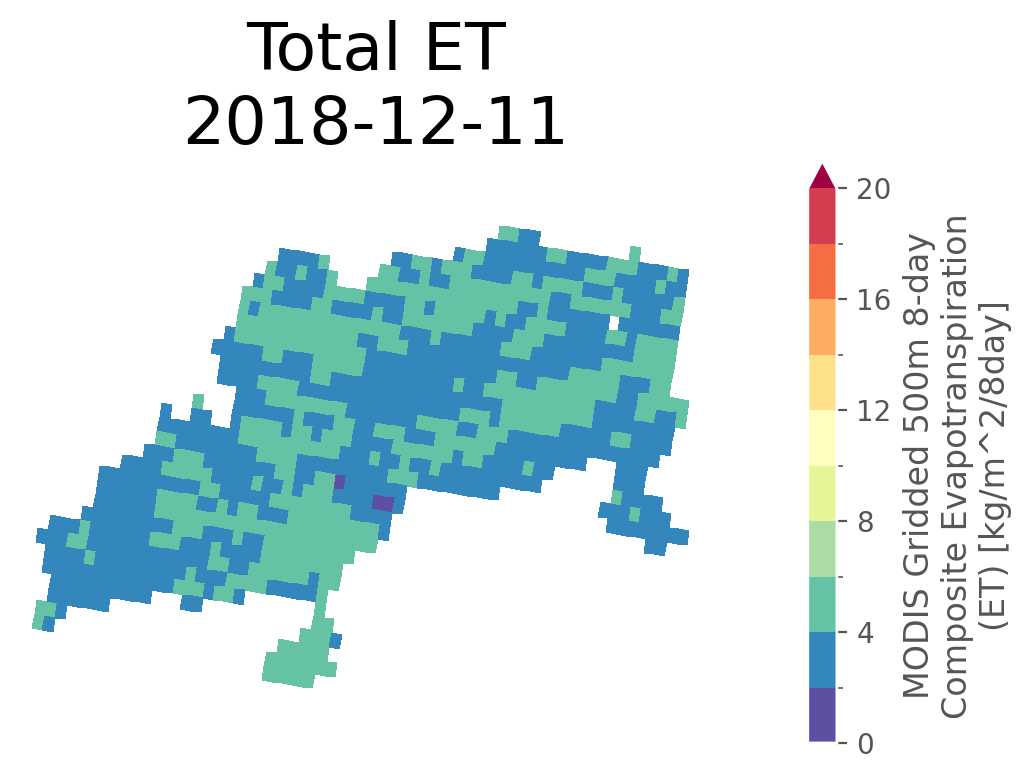

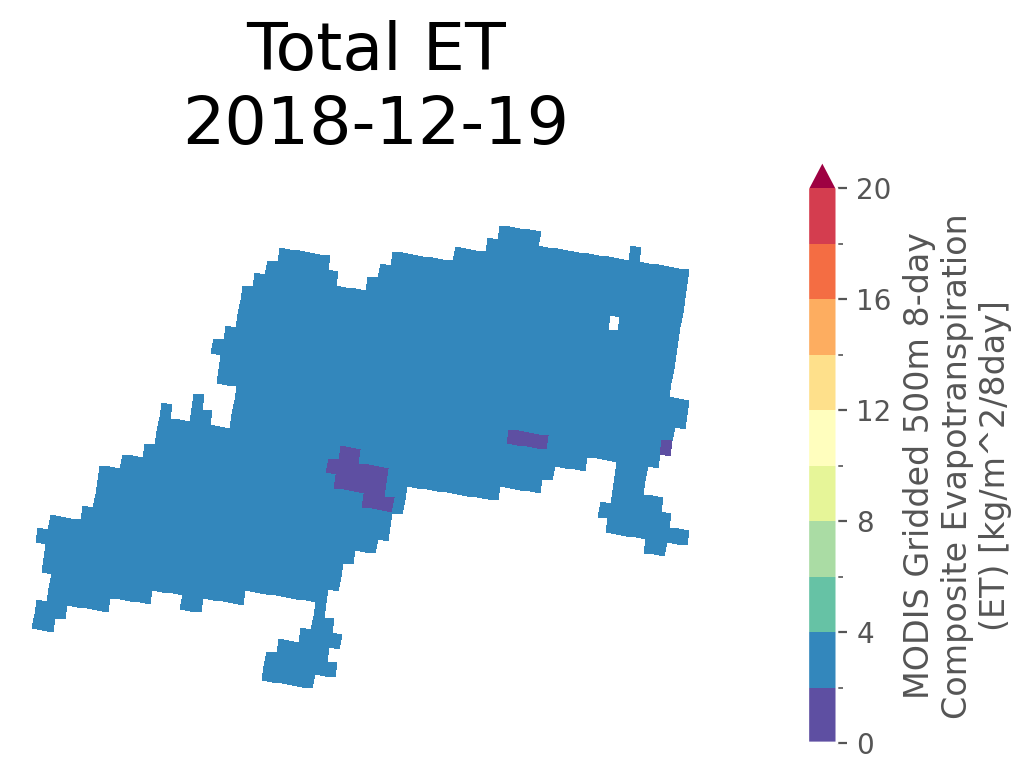

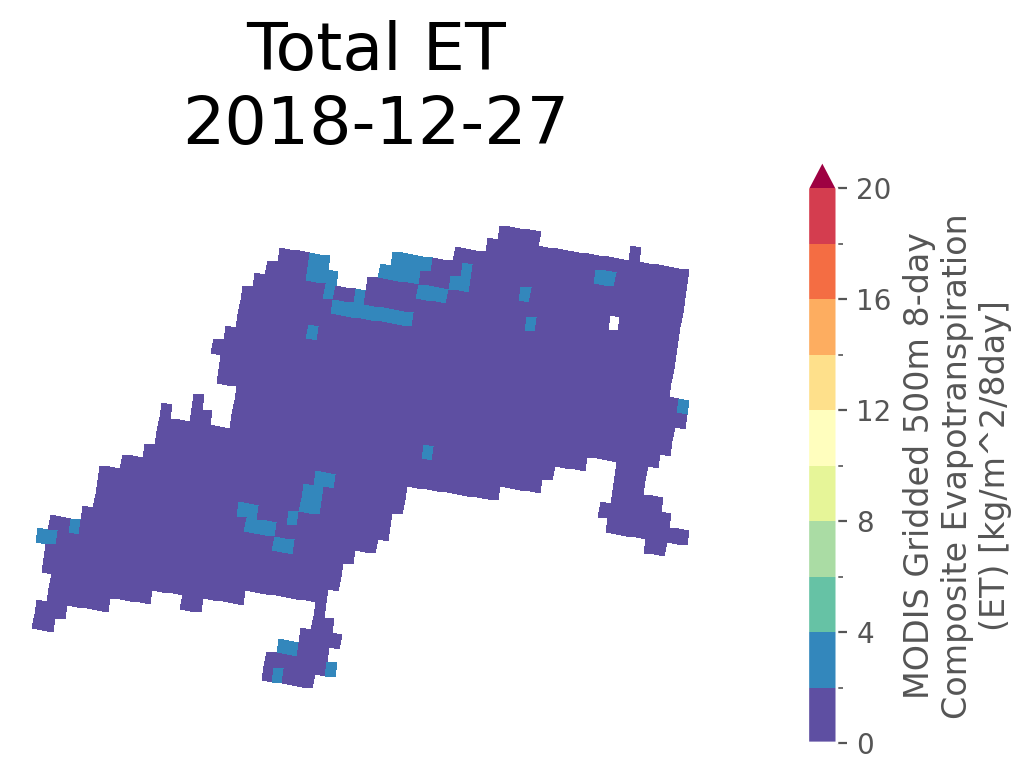

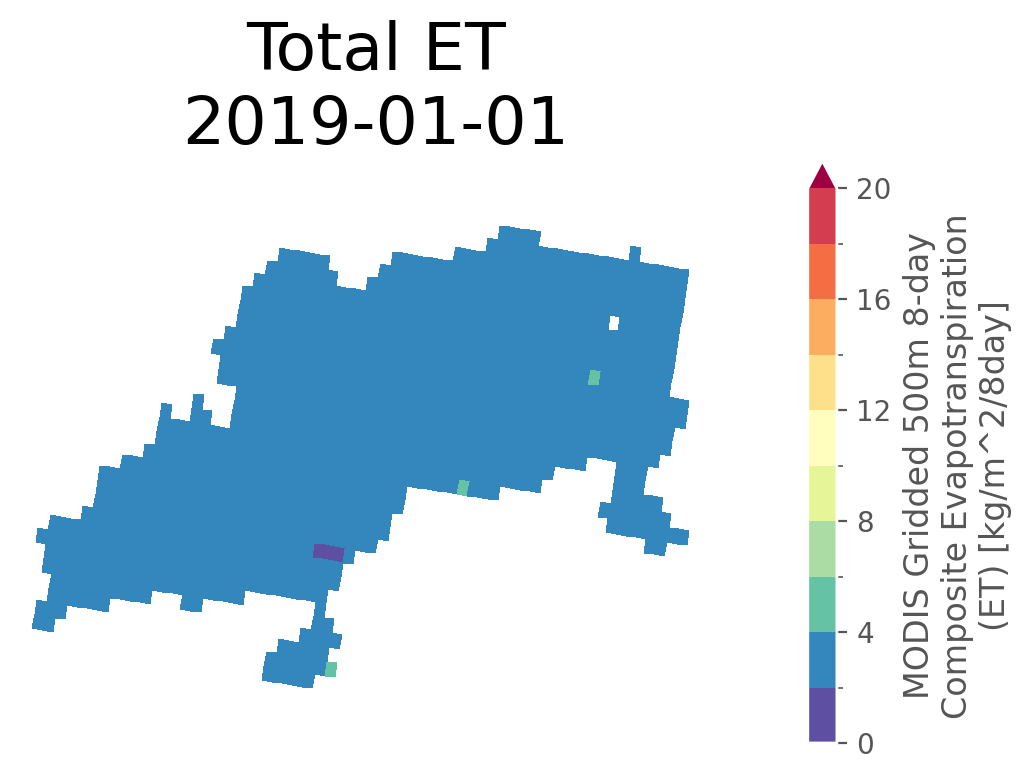

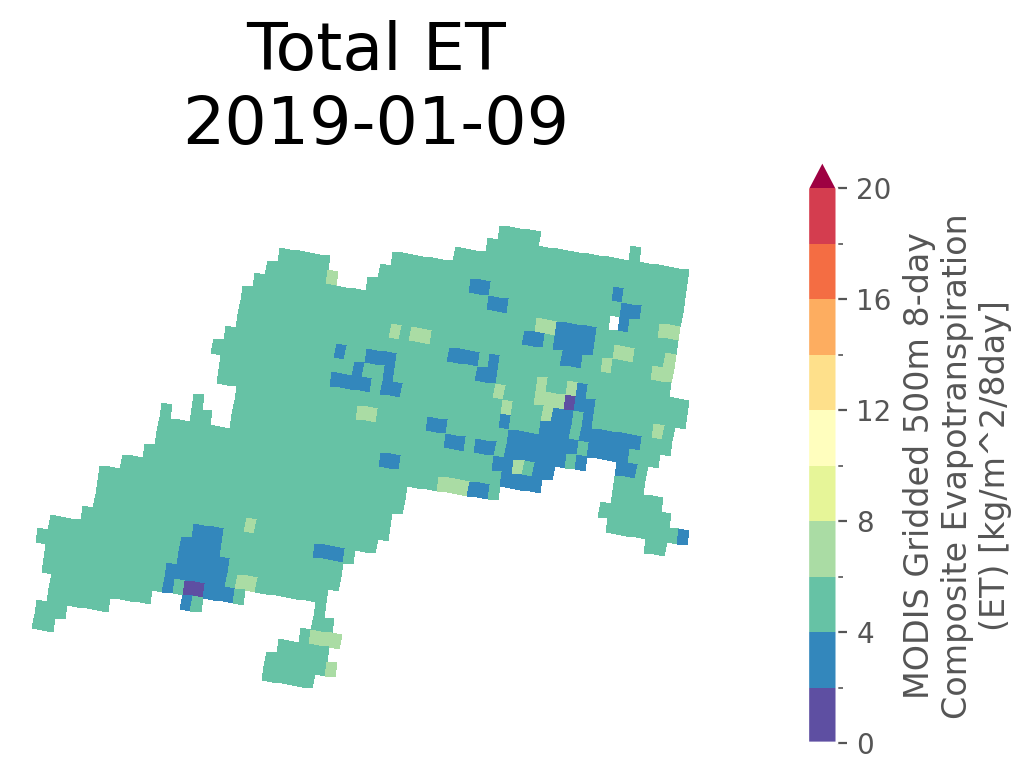

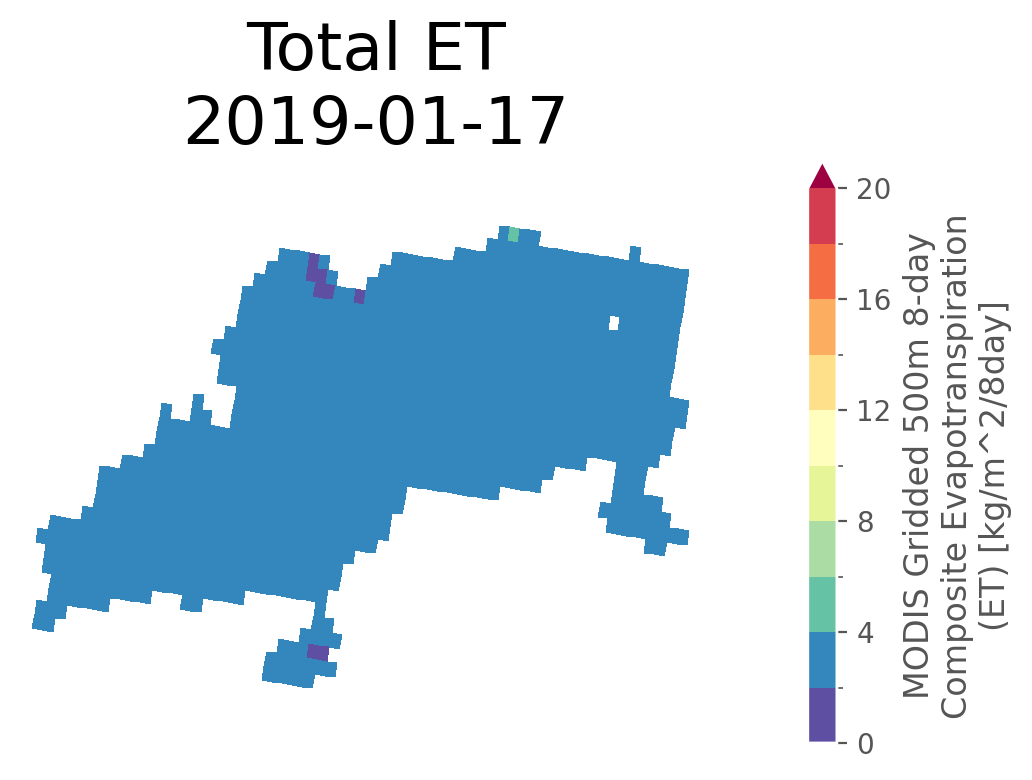

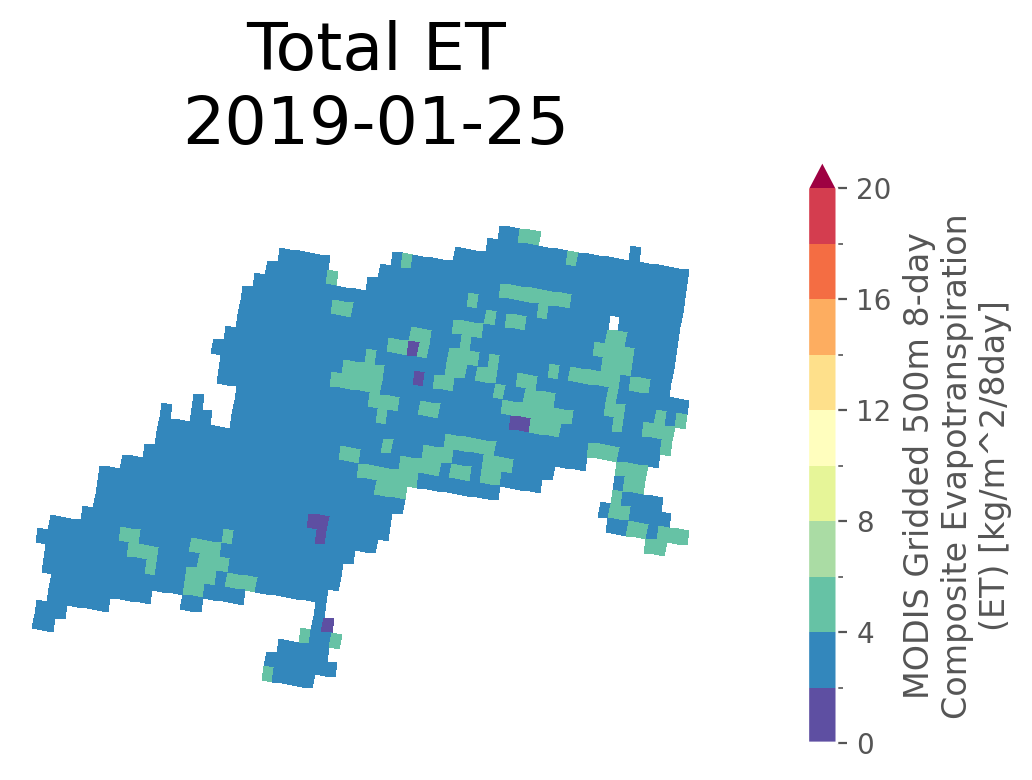

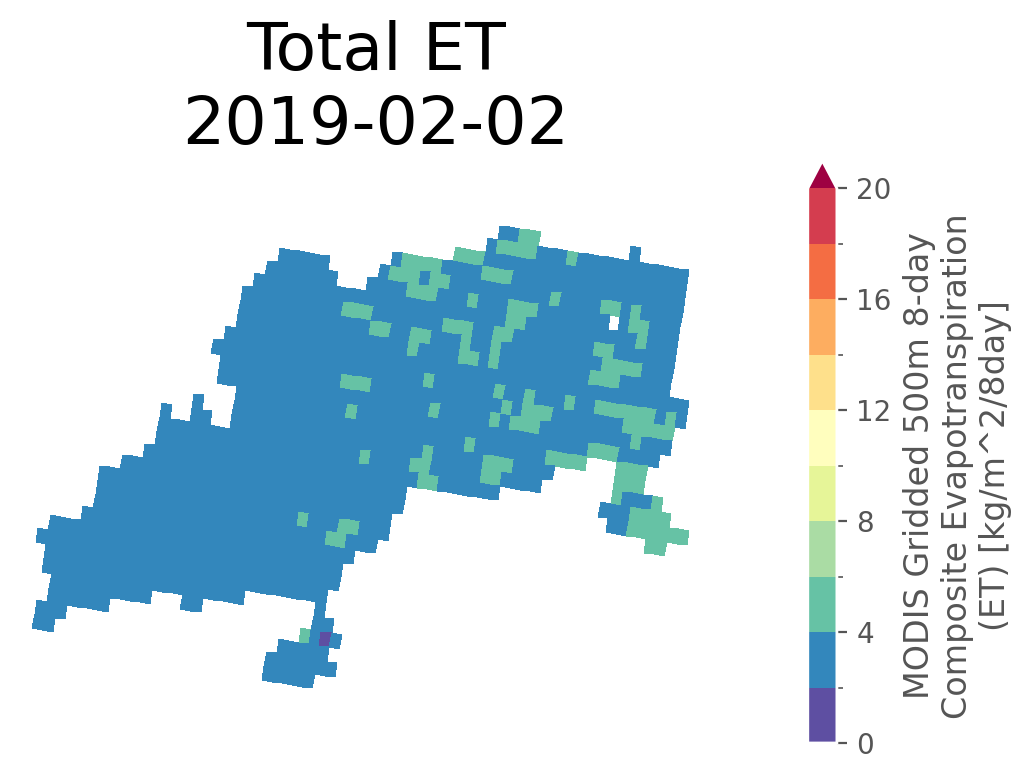

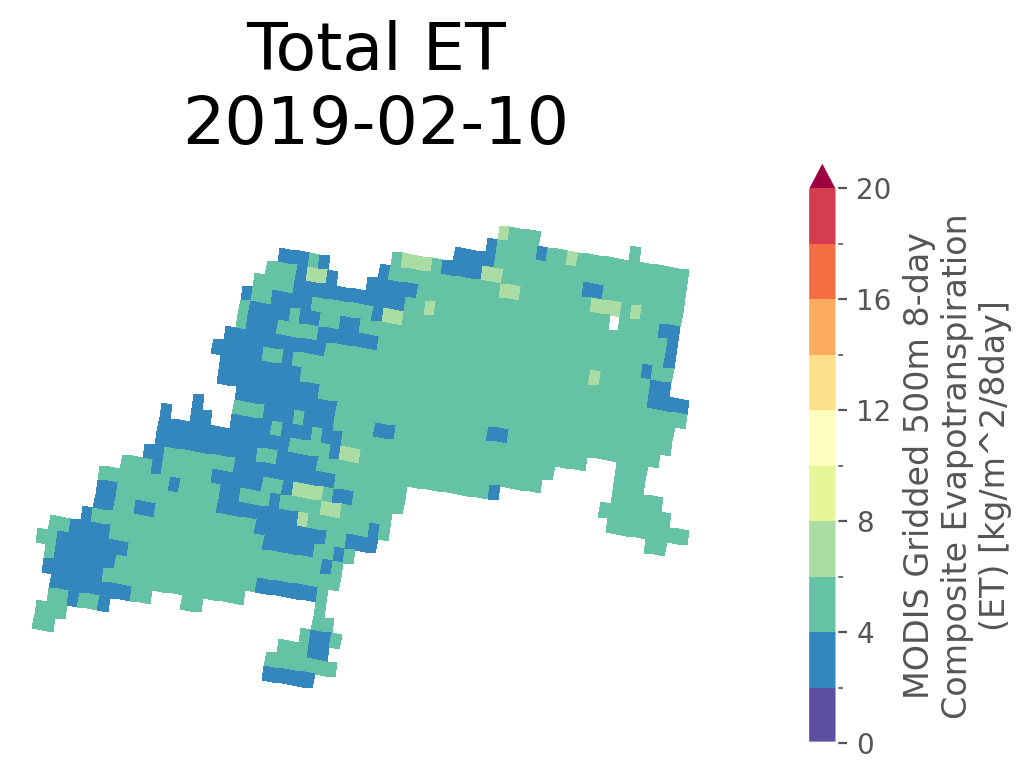

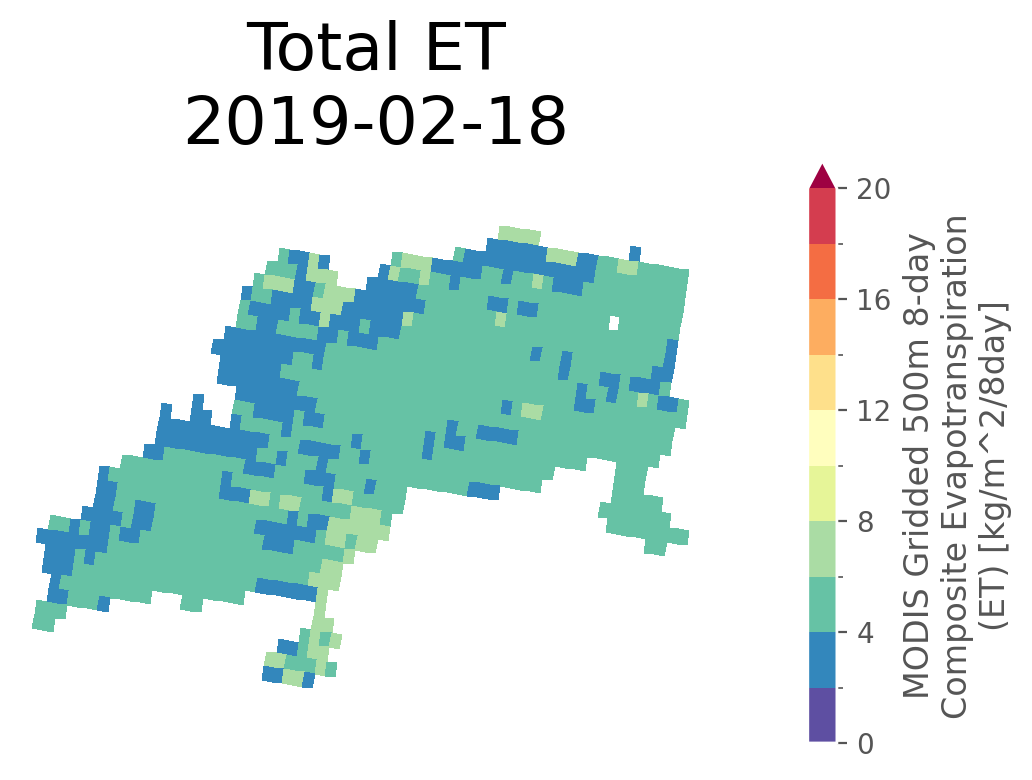

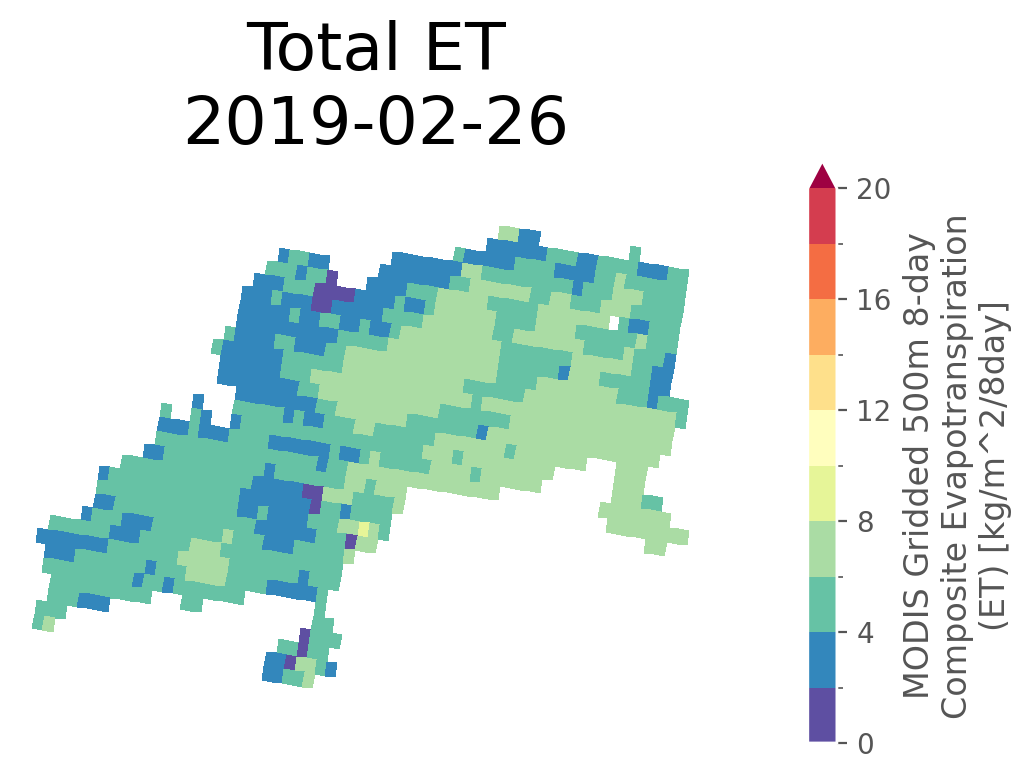

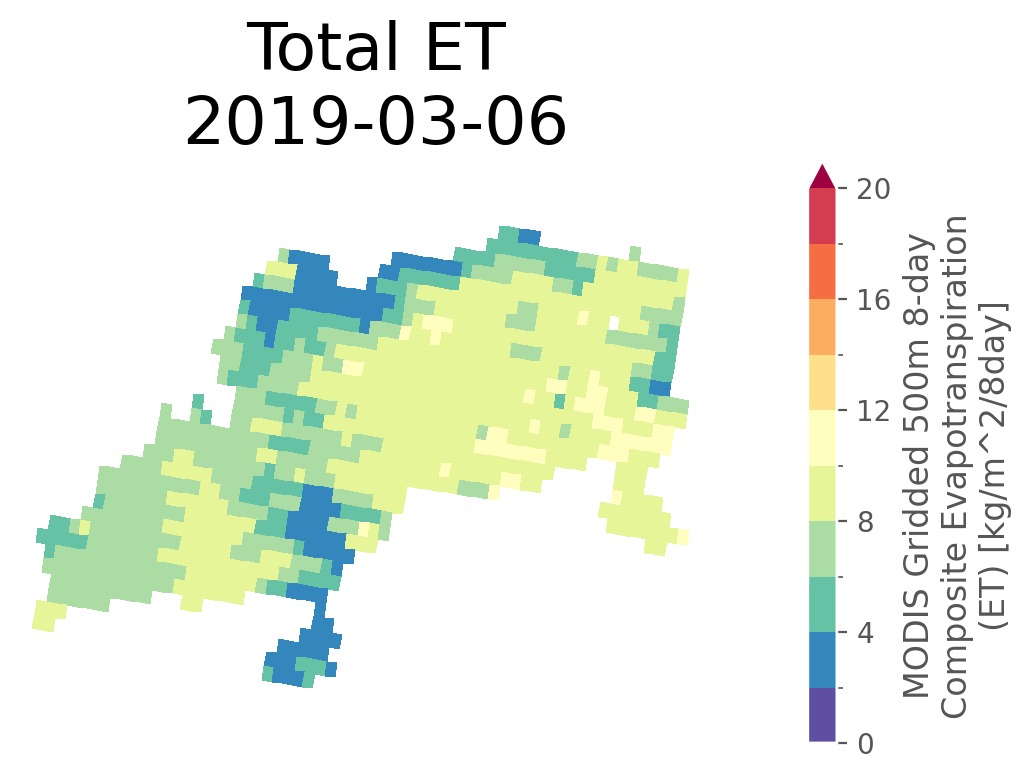

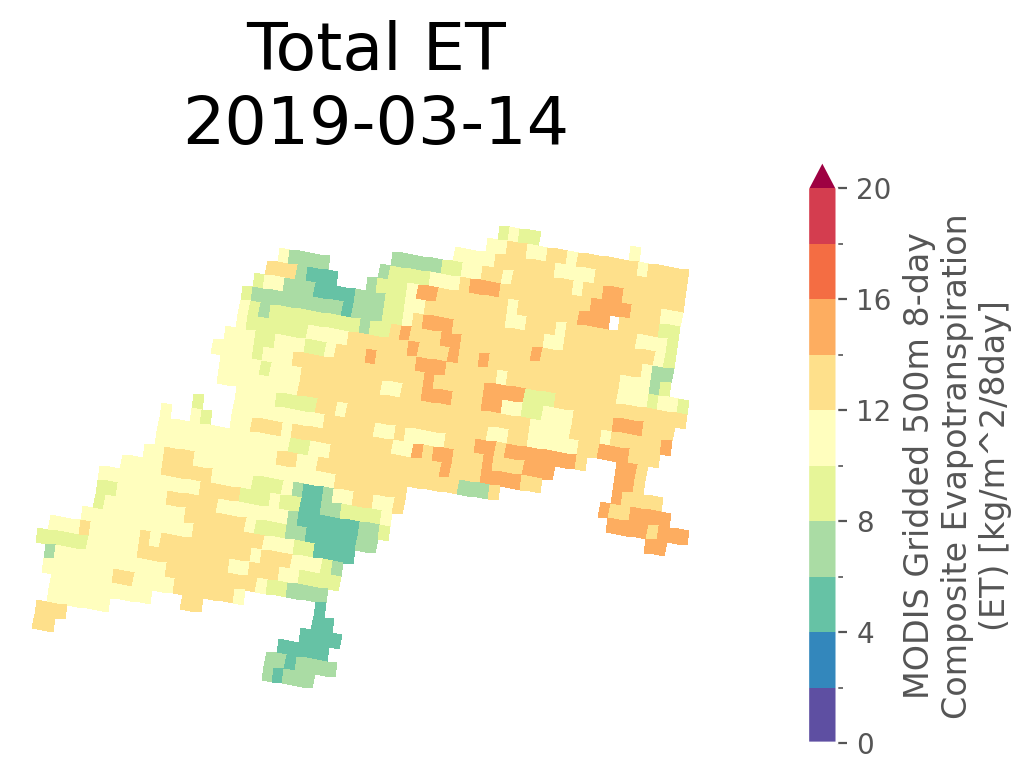

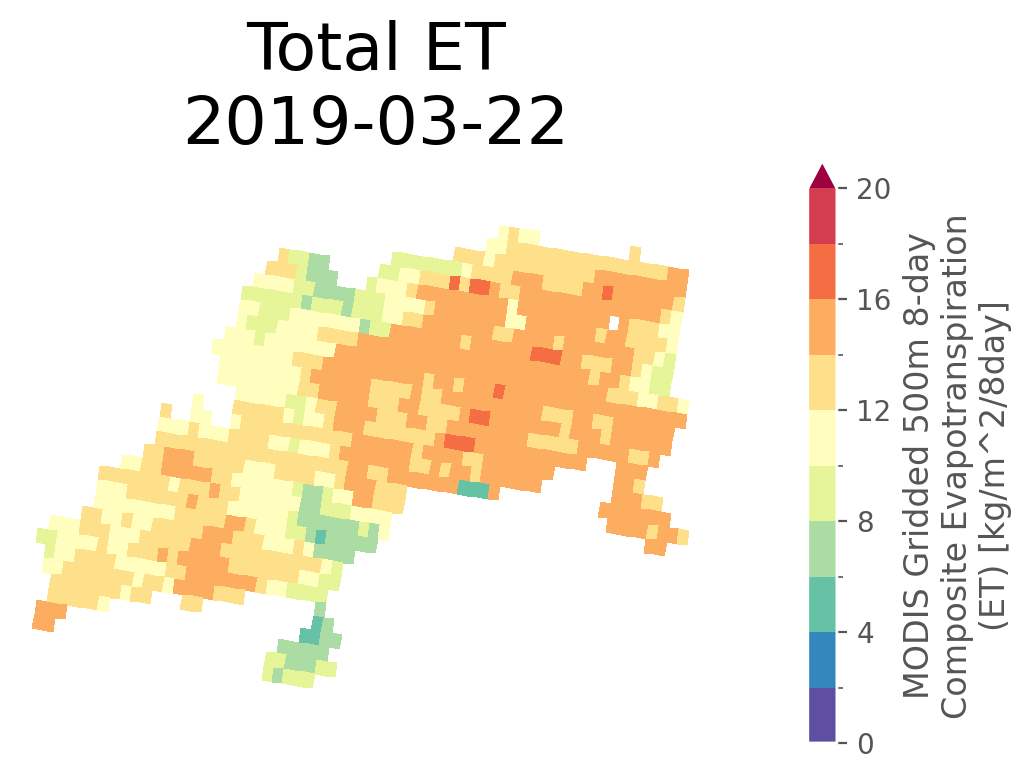

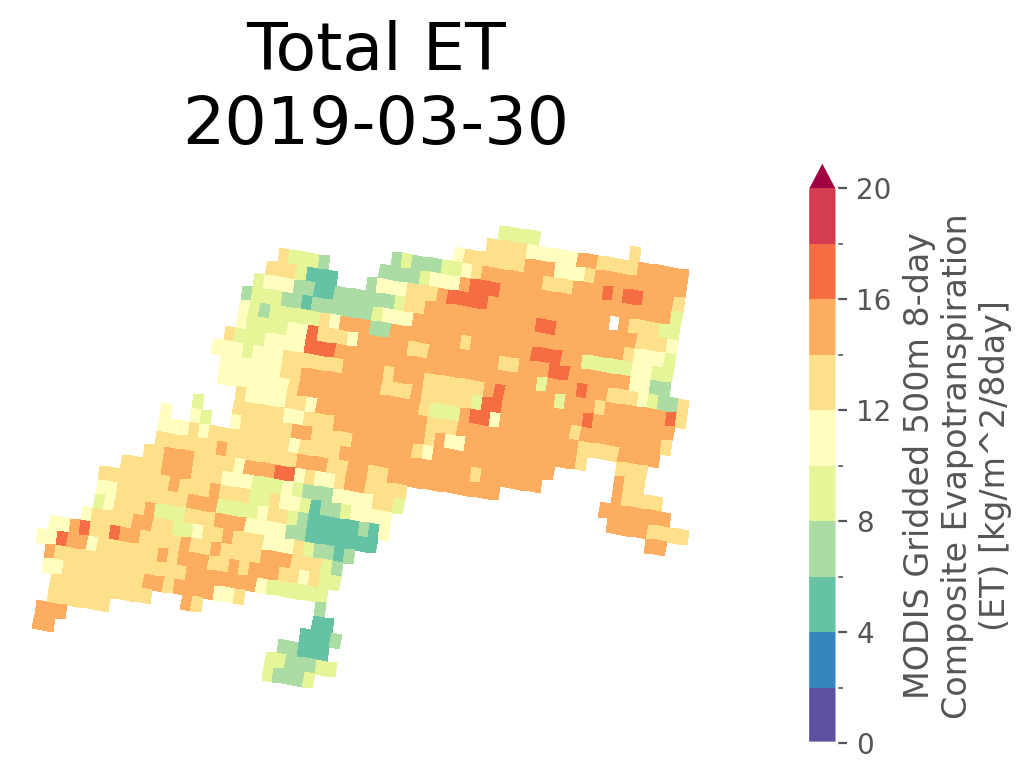


KeyboardInterrupt



In [29]:
for i, t in enumerate(ET_data.time.values[851:]):
    fig, ax = plt.subplots(1, 1, figsize=(8,4), subplot_kw={'projection': cartopy.crs.LambertConformal()})
    art = ET_data.isel(time=851+i).plot(ax=ax, levels=np.linspace(0,20,11), cmap='Spectral_r', extend='max', transform=cartopy.crs.PlateCarree())
    # fig.colorbar(art, label='[mm/d]', shrink=0.5, extend='max', orientation='vertical', pad=-0.05)
    ax.set_aspect('equal')
    ax.set_title(f'Total ET\n{str(t)[:10]}', fontsize=24)
    ax.set_facecolor('w')
    plt.tight_layout()
    # plt.savefig(f'./figs/{str(i).zfill(4)}.jpg', dpi=200)
    plt.show()

In [ ]:
from makegif import make_gif
make_gif('./figs/', fps=1.05, gif_fname='modis_et.gif')